# Setting a random seed

By setting a random seed when initilizing a model group or world generator, it is possible to have a deterministic output when having the same input arguments.

In [1]:
from pcg_gazebo.generators import WorldGenerator
from pcg_gazebo.visualization import plot_occupancy_grid, plot_workspace
from pcg_gazebo import random
world_gen = WorldGenerator()

PCG_RANDOM_SEED= None


In [2]:
from pcg_gazebo.generators.shapes import random_rectangles
from pcg_gazebo.generators.creators import extrude

wall_thickness = 0.15
wall_height = 2

wall_polygon = random_rectangles(
    n_rect=5, delta_x_min=15, delta_x_max=20, delta_y_min=15, delta_y_max=20)

walls_model = extrude(
    polygon=wall_polygon,
    thickness=wall_thickness,
    height=wall_height,
    pose=[0, 0, wall_height / 2., 0, 0, 0],
    extrude_boundaries=True,
    color='xkcd')
walls_model.name = 'walls'

print(walls_model.to_sdf())

<model name="walls">
  <pose frame="">0 0 1 0 -0 0</pose>
  <static>1</static>
  <self_collide>0</self_collide>
  <allow_auto_disable>0</allow_auto_disable>
  <link name="mesh">
    <kinematic>0</kinematic>
    <gravity>1</gravity>
    <self_collide>0</self_collide>
    <collision name="collision">
      <geometry>
        <mesh>
          <uri>file:///home/mam0box/.pcg/meshes/CfIsQkDBAM.stl</uri>
          <scale>1 1 1</scale>
        </mesh>
      </geometry>
      <pose frame="">2.20702 -0.350438 -1 0 -0 0</pose>
    </collision>
    <visual name="visual">
      <geometry>
        <mesh>
          <uri>file:///home/mam0box/.pcg/meshes/OziWOsPatZ.stl</uri>
          <scale>1 1 1</scale>
        </mesh>
      </geometry>
      <material>
        <ambient>0.780392 0.67451 0.490196 1</ambient>
        <diffuse>0.780392 0.67451 0.490196 1</diffuse>
      </material>
      <pose frame="">2.20702 -0.350438 -1 0 -0 0</pose>
      <cast_shadows>1</cast_shadows>
      <transparency>0.0</trans

/home/mam0box/Software/devel/pcg_gazebo/venv/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:


In [3]:
world_gen.add_asset(
    tag=walls_model.name,
    description=walls_model
)

True

In [4]:
world_gen.add_engine(
    engine_name='fixed_pose',
    tag='add_ground_plane',
    models=['ground_plane'],
    poses=[
        [0, 0, 0, 0, 0, 0]
    ]
)

world_gen.add_engine(
    engine_name='fixed_pose',
    tag='add_walls',
    models=[walls_model.name],
    poses=[
        [0, 0, wall_height / 2., 0, 0, 0]
    ]
)

True

In [5]:
world_gen.run_engines()

PCG_RANDOM_SEED= None


True

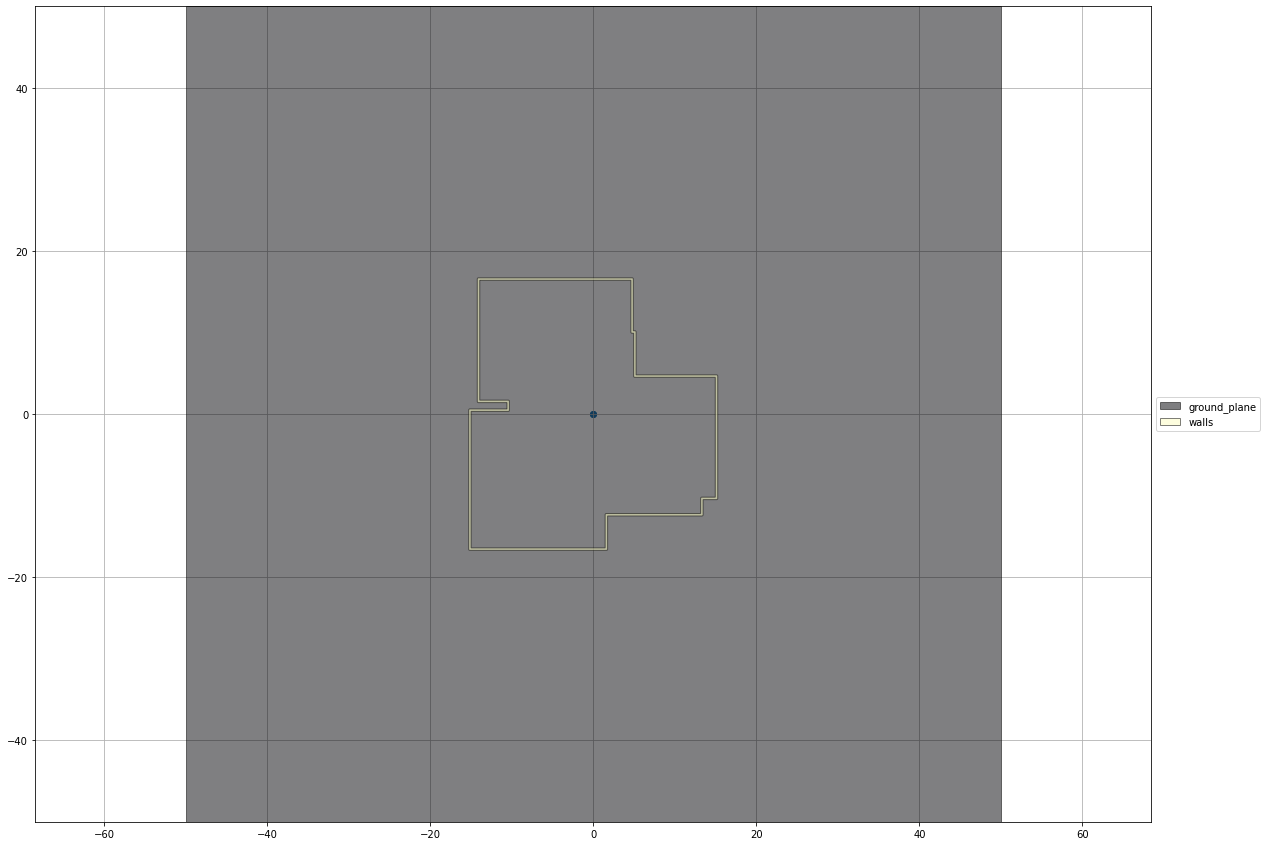

In [6]:
fig = world_gen.world.plot_footprints(engine='matplotlib')

In [7]:
print(world_gen.world.models)

{'ground_plane': <pcg_gazebo.simulation.model.SimulationModel object at 0x7faf0d5c1668>, 'walls': <pcg_gazebo.simulation.model.SimulationModel object at 0x7faf0c4ad668>}


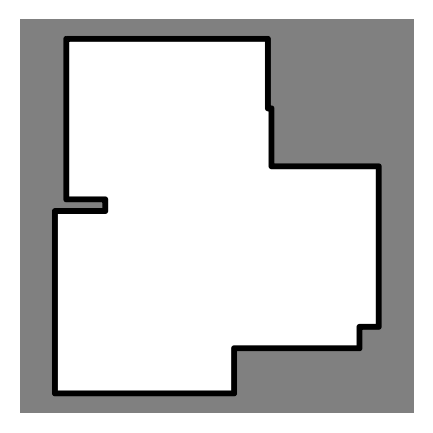

In [8]:
fig = plot_occupancy_grid(
    world_gen.world.models,
    with_ground_plane=True,
    static_models_only=False,
    exclude_contains=['ground_plane'],
    ground_plane_models=[walls_model.name])

(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faf0c4c5128>)

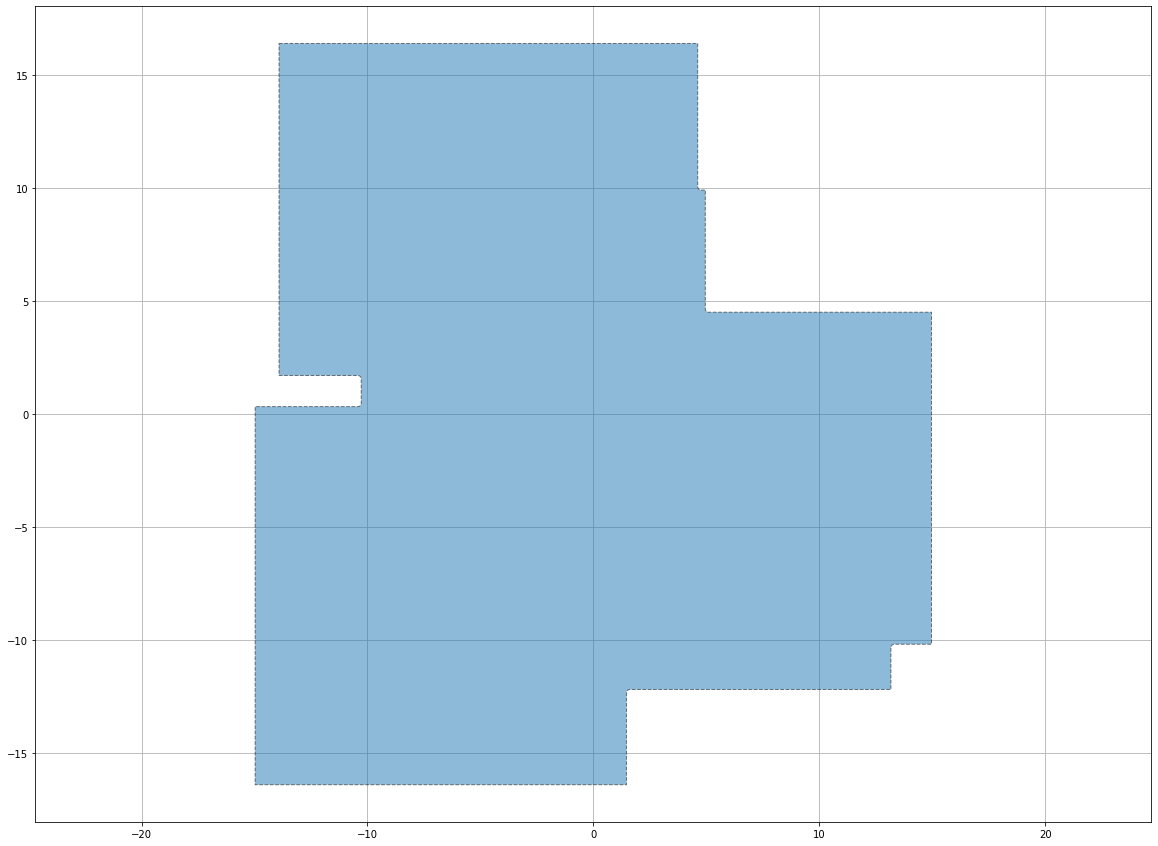

In [9]:
free_space_polygon = world_gen.world.get_free_space_polygon(
    ground_plane_models=[walls_model.name],
    ignore_models=['ground_plane'])

# Add the workspace constraint to the generator
world_gen.add_constraint(
    name='room_workspace',
    type='workspace',
    frame='world',
    geometry_type='polygon',
    polygon=free_space_polygon
)

plot_workspace(world_gen.constraints.get('room_workspace'))

In [10]:
world_gen.add_constraint(
    name='tangent_to_ground_plane',
    type='tangent',
    frame='world',
    reference=dict(
        type='plane',
        args=dict(
            origin=[0, 0, 0],
            normal=[0, 0, 1]
        )
    )
)

print('List of constraints=', list(world_gen.constraints.tags))

List of constraints= ['room_workspace', 'tangent_to_ground_plane']


Add some assets that will have their parameters dynamically generated when the engine is run.
This can be done using the model factory assets.

For that to happen, the inline commands that will be evaluated to return randomized values must use the internal `random` module in the `pcg_gazebo` package.

This module will make sure that the random seed object is shared by all calls of the random.

In [11]:
# Add cuboid model factory as an asset
world_gen.add_asset(
    tag='box',
    description=dict(
        type='box',
        args=dict(
            size="__import__('pcg_gazebo').random.rand(3)",
            mass="__import__('pcg_gazebo').random.rand()",
            name='cuboid',
            color='xkcd'
        )
    )
)

# Add sphere model factory as an asset
world_gen.add_asset(
    tag='sphere',
    description=dict(
        type='sphere',
        args=dict(
            radius="__import__('pcg_gazebo').random.rand()",
            mass="__import__('pcg_gazebo').random.rand()",
            name='sphere',
            color='xkcd'
        )
    )
)

# Add cylinder model factory as an asset
world_gen.add_asset(
    tag='cylinder',
    description=dict(
        type='cylinder',
        args=dict(
            radius="__import__('pcg_gazebo').random.rand()",
            length="max(0.5, __import__('pcg_gazebo').random.rand())",
            mass="__import__('pcg_gazebo').random.rand()",
            name='cylinder',
            color='xkcd'
        )
    )
)

True

In [12]:
NUM_CUBOIDS = 2
NUM_CYLINDER = 2
NUM_SPHERES = 2

placement_policy = dict(
    models=['box', 'cylinder', 'sphere'],
    config=[
        dict(
            dofs=['x', 'y'],            
            tag='workspace',
            workspace='room_workspace'
        ),
        dict(
            dofs=['roll', 'pitch', 'yaw'],        
            tag='uniform',                            
            min=-3.141592653589793,
            max=3.141592653589793               
        )
    ]
)

world_gen.add_engine(
    tag='object_placement',
    engine_name='random_pose',
    models=['box', 'cylinder', 'sphere'],
    max_num=dict(
        box=NUM_CUBOIDS,
        cylinder=NUM_CYLINDER,
        sphere=NUM_SPHERES),
    model_picker='random',
    no_collision=True,
    policies=[placement_policy],
    constraints=[
        dict(
            model='box',
            constraint='tangent_to_ground_plane'),
        dict(
            model='cylinder',
            constraint='tangent_to_ground_plane'),
        dict(
            model='sphere',
            constraint='tangent_to_ground_plane')
    ]
)

True

## Running engines multiple times without setting a seed

In [13]:
def generate_world():
    world_gen.init()
    world_gen.run_engines()

    print('List of models=', world_gen.world.models.keys())

    fig = plot_occupancy_grid(
        world_gen.world.models,
        with_ground_plane=True,
        static_models_only=False,
        exclude_contains=['ground_plane'],
        ground_plane_models=[walls_model.name])
    return world_gen.world.copy()

PCG_RANDOM_SEED= None
List of models= dict_keys(['ground_plane', 'walls', 'box', 'cylinder', 'cylinder_1', 'box_1', 'sphere', 'sphere_1'])
PCG_RANDOM_SEED= None
List of models= dict_keys(['ground_plane', 'walls', 'cylinder', 'cylinder_1', 'sphere', 'sphere_1', 'box', 'box_1'])
PCG_RANDOM_SEED= None
List of models= dict_keys(['ground_plane', 'walls', 'box', 'box_1', 'cylinder', 'cylinder_1', 'sphere', 'sphere_1'])


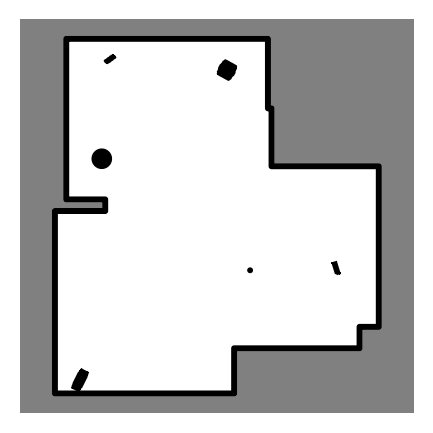

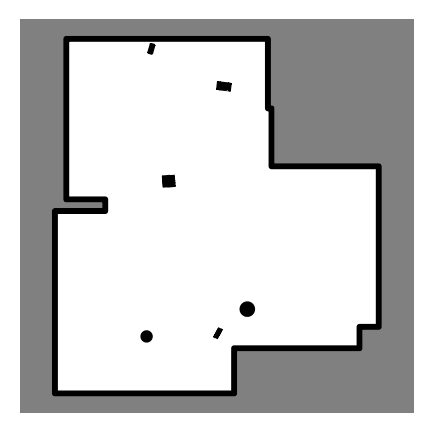

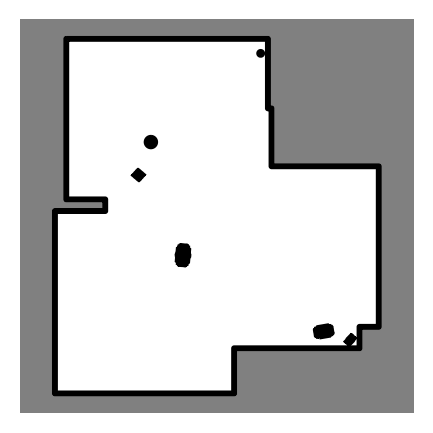

In [14]:
for _ in range(3):
    generate_world()

## Running engines multiple times with a seed

First, let's generate a reference world with a fixed seed.

Seed= 4770
PCG_RANDOM_SEED= 4770
List of models= dict_keys(['ground_plane', 'walls', 'box', 'box_1', 'cylinder', 'sphere', 'sphere_1', 'cylinder_1'])


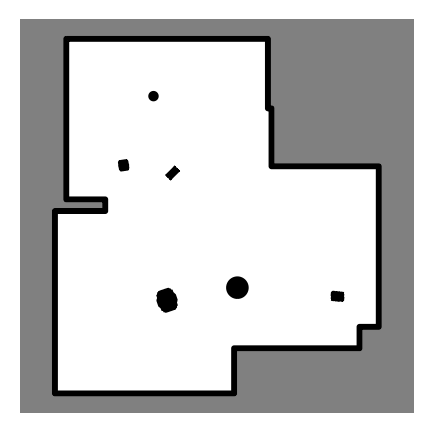

In [15]:
SEED = random.randint(0, 10000)
print('Seed=', SEED)
world_gen.seed = SEED
world_ref = generate_world()

PCG_RANDOM_SEED= 4770
List of models= dict_keys(['ground_plane', 'walls', 'box', 'box_1', 'cylinder', 'sphere', 'sphere_1', 'cylinder_1'])
PCG_RANDOM_SEED= 4770
List of models= dict_keys(['ground_plane', 'walls', 'box', 'box_1', 'cylinder', 'sphere', 'sphere_1', 'cylinder_1'])
PCG_RANDOM_SEED= 4770
List of models= dict_keys(['ground_plane', 'walls', 'box', 'box_1', 'cylinder', 'sphere', 'sphere_1', 'cylinder_1'])


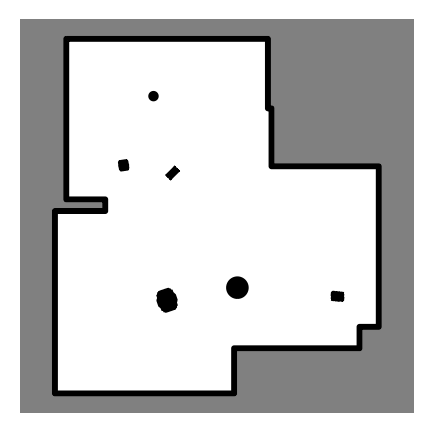

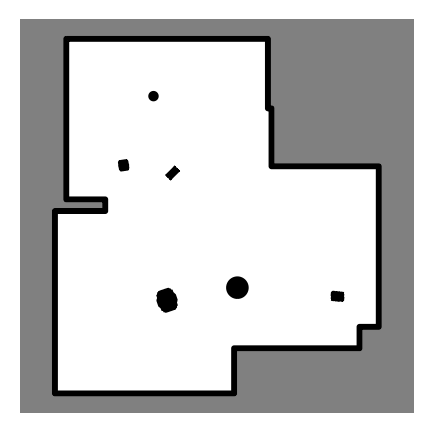

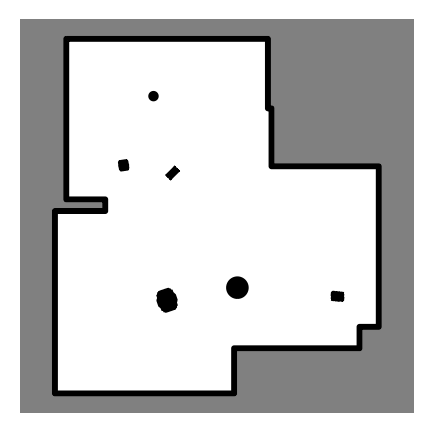

In [16]:
worlds = list()
for _ in range(3):
    worlds.append(generate_world())

Compare the worlds generated with the reference to check that the same seed produces the same world for the same inputs.

In [17]:
for i in range(len(worlds)):
    print('Is world #{} equal to reference? '.format(i), world_ref == worlds[i])

Is world #0 equal to reference?  True
Is world #1 equal to reference?  True
Is world #2 equal to reference?  True
